# Segmentation ResNet18 from Kaggle

> Pytorch solution from Kaggle.

This notebook uses a UNet model with pretrained resnet18 encoder, with simple augmentations using albumentations library, uses BCE loss, metrics like Dice and IoU. The segmentation model is from [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) which comes with a lot pre-implemented segmentation architectures. 

The kaggle kernel from which I've borrowed this code is: https://www.kaggle.com/rishabhiitbhu/unet-pytorch-inference-kernel.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from steel_segmentation.core import *
from steel_segmentation.data import *
from steel_segmentation.models.unet import Unet
from steel_segmentation.models.model import *

from matplotlib import pyplot as plt

import warnings
import random
import os
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as data
import albumentations as alb
from albumentations.pytorch import ToTensor

warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
torch.device("cuda:0").type

'cuda'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
model = Unet("resnet18", encoder_weights="imagenet",
             classes=4, activation=None)

In [ ]:
model_trainer = Trainer(model, save_path=models_dir/"kaggle_ResNet18-Unet.pth")

In [ ]:
# loaded_dict = torch.load(models_dir/"kaggle_model.pth")
# model_trainer.net.load_state_dict(loaded_dict["state_dict"], strict=True)

## Training

In [ ]:
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 20:22:28
Loss: 0.3524 | IoU: 0.0206 | dice: 0.0324 | dice_neg: nan | dice_pos: 0.0324
Starting epoch: 0 | phase: val | ⏰: 20:30:15
Loss: 0.2505 | IoU: 0.0457 | dice: 0.0624 | dice_neg: nan | dice_pos: 0.0624
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 20:31:29
Loss: 0.2032 | IoU: 0.0446 | dice: 0.0603 | dice_neg: nan | dice_pos: 0.0603
Starting epoch: 1 | phase: val | ⏰: 20:39:04
Loss: 0.1600 | IoU: 0.0544 | dice: 0.0711 | dice_neg: nan | dice_pos: 0.0711
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 20:40:15
Loss: 0.1264 | IoU: 0.3621 | dice: 0.4650 | dice_neg: nan | dice_pos: 0.4650
Starting epoch: 2 | phase: val | ⏰: 20:48:02
Loss: 0.0993 | IoU: 0.4368 | dice: 0.5465 | dice_neg: nan | dice_pos: 0.5465
******** New optimal found, saving state ********

Starting epoch: 3 | phase: train | ⏰: 20:49:15
Loss: 0.0831 | IoU: 0.4060 | dice: 0.5147 | dice_neg: nan | di

## Results

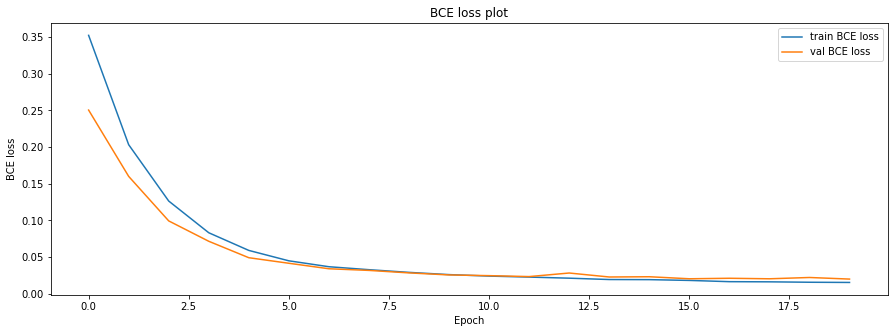

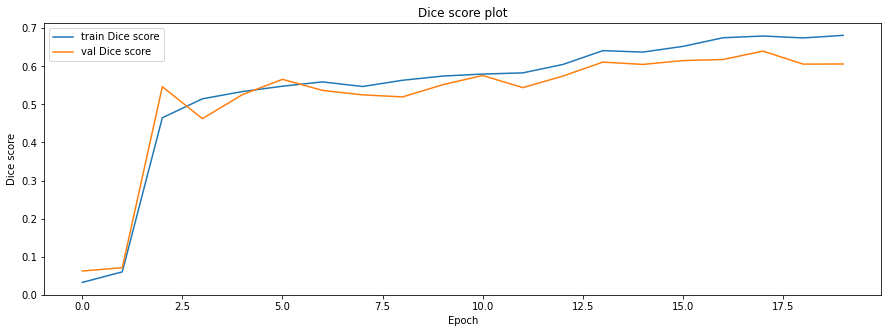

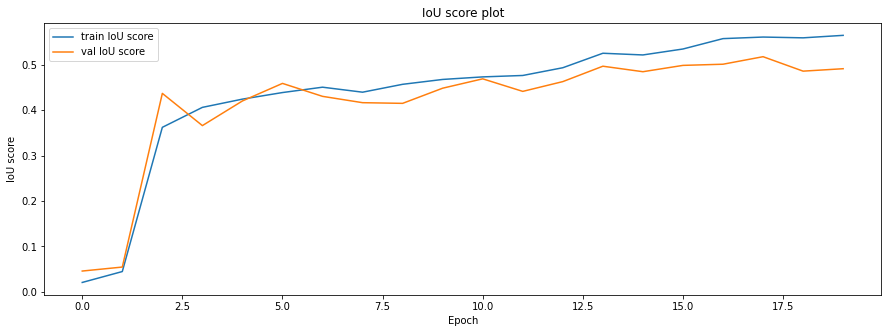

In [ ]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores  # overall dice
iou_scores = model_trainer.iou_scores


def plot(scores, name):
    plt.figure(figsize=(15, 5))
    plt.plot(range(len(scores["train"])),
             scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot')
    plt.xlabel('Epoch')
    plt.ylabel(f'{name}')
    plt.legend()
    plt.show()


plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

This training and validation takes about ~400 minutes which exceeds Kaggle's GPU usage limit of 60 minutes, we won't be able to submit the `submission.csv` file generated from this kernel. So, for test prediction and submission I've written a separate [UNet inference kernel](https://www.kaggle.com/rishabhiitbhu/unet-pytorch-inference-kernel), make sure you add the `model.pth` file generated from this kernel as dataset to test inference kernel.

## Inference

In [ ]:
def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((256, 1600), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [ ]:
sample_submission_path = path / 'sample_submission.csv'
test_data_folder = path / "test_images"

In [ ]:
testset = get_kaggle_test_dls(sample_submission_path)

In [ ]:
# Initialize mode and load trained weights
ckpt_path = "model.pth"
device = torch.device("cuda")
model = Unet("resnet18", encoder_weights=None, classes=4, activation=None)
model.to(device)
model.eval()
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

In [ ]:
# start prediction
predictions = []
for i, batch in enumerate(tqdm(testset)):
    fnames, images = batch
    batch_preds = torch.sigmoid(model(images.to(device)))
    batch_preds = batch_preds.detach().cpu().numpy()
    for fname, preds in zip(fnames, batch_preds):
        for cls, pred in enumerate(preds):
            pred, num = post_process(pred, best_threshold, min_size)
            rle = mask2rle(pred)
            name = fname + f"_{cls+1}"
            predictions.append([name, rle])

# save predictions to submission.csv
df = pd.DataFrame(predictions, columns=['ImageId_ClassId', 'EncodedPixels'])
df.to_csv("submission.csv", index=False)

In [ ]:
df.head()

## Refrences

